In [ ]:
#import all the packages and modules I need.
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
import subprocess
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


您可以通过以下步骤修改Colab的计算单元（CPU、GPU、TPU）：

1. 在Colab笔记本中，点击顶部菜单栏中的“运行时”（Runtime）。
2. 在下拉菜单中选择“更改运行时类型”（Change runtime type）。
3. 在弹出的对话框中，找到“硬件加速器”（Hardware accelerator）选项。
4. 您可以选择“None”（CPU）、“GPU”（如Tesla P100、T4、A100等，具体可用型号取决于您的Colab版本和配额）或“TPU”。
5. 选择您需要的硬件加速器，然后点击“保存”。

请注意，更改运行时类型会重新启动运行时，这意味着您的所有变量和状态都将被重置，需要重新运行之前的代码单元。

Getting the data. In the following training, I'll only use the mass=1000 dataset, clearly this frame can be trained on other data of mass not equal to 1000.

In [ ]:
def wget_data(url: str):#helper function to obtain the data
    local_path = './tmp_data'
    p = subprocess.Popen(["wget", "-nc", "-P", local_path, url], stderr=subprocess.PIPE, encoding='UTF-8')
    rc = None
    while rc is None:
      line = p.stderr.readline().strip('\n')
      if len(line) > 0:
        print(line)
      rc = p.poll()

def locate_data(name, check_exists=True):
    local_path='./tmp_data'
    path = os.path.join(local_path, name)
    if check_exists and not os.path.exists(path):
        raise RuxntimeError('No such data file: {}'.format(path))
    return path

In [ ]:
wget_data("https://courses.physics.illinois.edu/phys498mlp/sp2025/data/projects/ExoticParticles/hepmass/1000_train.csv.gz")
wget_data("https://courses.physics.illinois.edu/phys498mlp/sp2025/data/projects/ExoticParticles/hepmass/not1000_train.csv.gz")
wget_data("https://courses.physics.illinois.edu/phys503/fa2023/data/projects/ExoticParticles/hepmass/1000_test.csv.gz")
wget_data("https://courses.physics.illinois.edu/phys503/fa2023/data/projects/ExoticParticles/hepmass/not1000_test.csv.gz")

流式输出内容被截断，只能显示最后 5000 行内容。
609100K .......... .......... .......... .......... .......... 70%  692M 29s
609150K .......... .......... .......... .......... .......... 70%  514K 29s
609200K .......... .......... .......... .......... .......... 70%  216M 29s
609250K .......... .......... .......... .......... .......... 70%  351M 29s
609300K .......... .......... .......... .......... .......... 70%  515M 29s
609350K .......... .......... .......... .......... .......... 70%  601M 29s
609400K .......... .......... .......... .......... .......... 70%  110M 29s
609450K .......... .......... .......... .......... .......... 70%  310M 29s
609500K .......... .......... .......... .......... .......... 70%  616M 29s
609550K .......... .......... .......... .......... .......... 70%  505M 29s
609600K .......... .......... .......... .......... .......... 70%  135M 29s
609650K .......... .......... .......... .......... .......... 70%  646M 29s
609700K .......... .......... .......... ........

In [ ]:
thousand_test = pd.read_csv(locate_data("1000_test.csv.gz"), skiprows=[0], header = None)
thousand_train = pd.read_csv(locate_data("1000_train.csv.gz"), skiprows=[0], header = None)

thousand_train.columns = ['# label','f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13','f14','f15','f16','f17','f18','f19','f20','f21','f22','f23','f24','f25','f26']
thousand_test.columns = ['# label','f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13','f14','f15','f16','f17','f18','f19','f20','f21','f22','f23','f24','f25','f26']
#convert the dataframe into the numpy array
X_1000_train_np = thousand_train.drop(columns=['# label']).to_numpy().astype('float32')
y_1000_train_np = thousand_train['# label'].to_numpy().astype('float32')

X_1000_test_np  = thousand_test.drop(columns=['# label']).to_numpy().astype('float32')
y_1000_test_np  = thousand_test['# label'].to_numpy().astype('float32')

In [ ]:
not_thousand_test = pd.read_csv(locate_data("not1000_test.csv.gz"))
not_thousand_train = pd.read_csv(locate_data("not1000_train.csv.gz"))
not_thousand_train.columns = ['# label','f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13','f14','f15','f16','f17','f18','f19','f20','f21','f22','f23','f24','f25','f26','f27']
not_thousand_test.columns = ['# label','f0','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10','f11','f12','f13','f14','f15','f16','f17','f18','f19','f20','f21','f22','f23','f24','f25','f26','f27']
X_N1000_train = torch.tensor(not_thousand_train.drop(columns=['# label']).values, dtype=torch.float32)
y_N1000_train = torch.tensor(not_thousand_train['# label'].values, dtype=torch.float32)
X_N1000_test = torch.tensor(not_thousand_test.drop(columns=['# label']).values, dtype=torch.float32)
y_N1000_test = torch.tensor(not_thousand_test['# label'].values, dtype=torch.float32)

Construct the shallow Neural network.

For the shallow netowrk, we have one layer of 100 hidden units. The forward propagation is just the most usual one since this is shallow neural network.


In [ ]:
class ShallowNN(nn.Module):
    def __init__(self, input_dim, hidden_units=100):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, 1)
        )# All connected neural network with relu as activation function.

    def forward(self, x):
        return self.model(x)




The loss function is the binary cross entropy loss: $2L=p\ln{p}+(1-p)\ln{(1-p)}$.

In [ ]:
def train_model(model, train_loader, val_loader, device, epochs=50, lr=0.01):
    criterion = nn.BCEWithLogitsLoss()

    optimizer = optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=0.9,
        nesterov=True
    )

    model.to(device)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).view(-1, 1)

            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Evaluate AUC
        val_auc = evaluate_auc(model, val_loader, device)

        print(f"Epoch {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Val AUC: {val_auc:.4f}")


Evluate AUC

In [ ]:
def evaluate_auc(model, loader, device):
    model.eval()
    preds_list, labels_list = [], []

    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds = model(xb).cpu().numpy().flatten()
            preds_list.extend(preds)
            labels_list.extend(yb.numpy().flatten())

    return roc_auc_score(labels_list, preds_list)


In [ ]:
#standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_1000_train_np)
X_test_scaled  = scaler.transform(X_1000_test_np)

#NumPy → torch.tensor
X_1000_train = torch.tensor(X_train_scaled, dtype=torch.float32)
y_1000_train = torch.tensor(y_1000_train_np, dtype=torch.float32)

X_1000_test  = torch.tensor(X_test_scaled, dtype=torch.float32)
y_1000_test  = torch.tensor(y_1000_test_np, dtype=torch.float32)



train_1000_ds = TensorDataset(X_1000_train, y_1000_train)
test_1000_ds = TensorDataset(X_1000_test, y_1000_test)

#split the training set into training and validation set
train_size = int(0.8*len(train_1000_ds))
val_size = len(train_1000_ds) - train_size

train_1000_ds, val_1000_ds = random_split(train_1000_ds,[train_size, val_size])

train_1000_loader = DataLoader(train_1000_ds, batch_size=100, shuffle=True)
val_1000_loader = DataLoader(val_1000_ds, batch_size=100, shuffle = True)
test_1000_loader = DataLoader(test_1000_ds, batch_size=1000)

input_dim = X_1000_train.shape[1]

model = ShallowNN(input_dim=input_dim, hidden_units=100)  # pick 100/300/500

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_model(
    model=model,
    train_loader=train_1000_loader,
    val_loader=val_1000_loader,
    device=device,
    epochs=50,
    lr=0.01
)

Epoch 1/50 | Loss: 11956.3003 | Val AUC: 0.9716
Epoch 2/50 | Loss: 11560.8794 | Val AUC: 0.9720
Epoch 3/50 | Loss: 11446.4656 | Val AUC: 0.9721
Epoch 4/50 | Loss: 11379.6782 | Val AUC: 0.9725
Epoch 5/50 | Loss: 11339.8012 | Val AUC: 0.9726
Epoch 6/50 | Loss: 11307.9470 | Val AUC: 0.9727
Epoch 7/50 | Loss: 11278.2776 | Val AUC: 0.9730
Epoch 8/50 | Loss: 11246.7375 | Val AUC: 0.9731
Epoch 9/50 | Loss: 11223.4483 | Val AUC: 0.9733
Epoch 10/50 | Loss: 11209.8472 | Val AUC: 0.9732
Epoch 11/50 | Loss: 11199.8575 | Val AUC: 0.9733
Epoch 12/50 | Loss: 11191.6863 | Val AUC: 0.9732
Epoch 13/50 | Loss: 11182.7450 | Val AUC: 0.9734
Epoch 14/50 | Loss: 11175.9049 | Val AUC: 0.9734
Epoch 15/50 | Loss: 11168.7090 | Val AUC: 0.9735
Epoch 16/50 | Loss: 11163.4005 | Val AUC: 0.9734
Epoch 17/50 | Loss: 11154.2403 | Val AUC: 0.9737
Epoch 18/50 | Loss: 11149.9463 | Val AUC: 0.9735
Epoch 19/50 | Loss: 11148.3744 | Val AUC: 0.9735
Epoch 20/50 | Loss: 11145.2707 | Val AUC: 0.9735
Epoch 21/50 | Loss: 11141.679

In [ ]:
def get_predictions(model, loader, device):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            y = y.to(device)

            preds = model(X).cpu().numpy().flatten()
            y_pred.extend(preds)
            y_true.extend(y.cpu().numpy().flatten())

    return np.array(y_true), np.array(y_pred)

In [ ]:
def plot_output_distribution(y_true, y_pred):
    signal_pred = y_pred[y_true == 1]
    background_pred = y_pred[y_true == 0]

    plt.figure(figsize=(8,5))
    plt.hist(signal_pred, bins=50, alpha=0.6, density=True, label="Signal")
    plt.hist(background_pred, bins=50, alpha=0.6, density=True, label="Background")
    plt.xlabel("NN output")
    plt.ylabel("Density")
    plt.legend()
    plt.title("Shallow NN Output Distribution")
    plt.show()

In [ ]:
def plot_roc_curve(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1], [0,1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return roc_auc

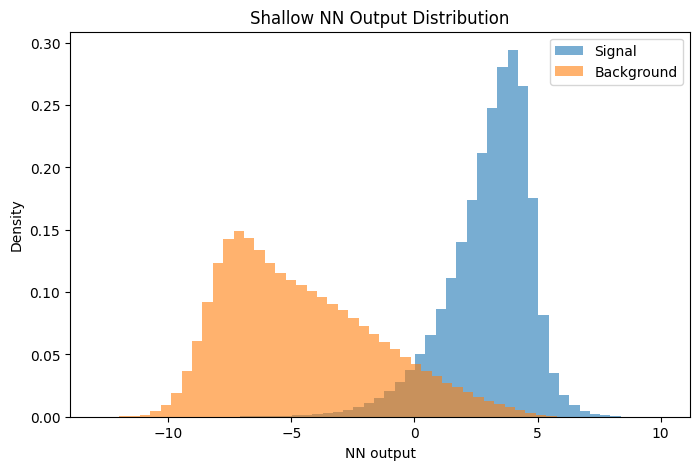

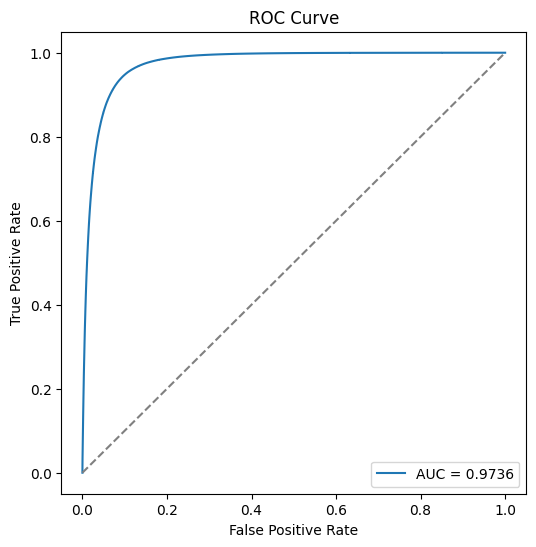

AUC: 0.9735834855720575


In [ ]:
# Get predictions
y_true, y_pred = get_predictions(model, test_1000_loader, device)

# Output distributions
plot_output_distribution(y_true, y_pred)

# ROC curve & AUC
auc_value = plot_roc_curve(y_true, y_pred)
print("AUC:", auc_value)

Construct the deep neural network.

For the deep network, we have 3 layers of 100 hidden units (of course, tunable). To avoid the gradient vanishing or gradient explosion, we use residual connection.

In [ ]:
class DeepNN(nn.Module):
    def __init__(self, input_dim, hidden_units=100,n_hiddenlayers = 3):
        super().__init__()
        self.activation = nn.ReLU()

        #dynamically define the architecture
        self.layer_size = [input_dim]+[hidden_units]*n_hiddenlayers+[1]
        layer_list = [nn.Linear(self.layer_size[idx-1],self.layer_size[idx]) for idx in range(1,len(self.layer_size))]
        self.layer = nn.ModuleList(layer_list)


    def forward(self, input):
        hidden = self.activation(self.layer[0](input))
        for layer in self.layer[1:-1]:
          hidden = self.activation(layer(hidden))+ hidden#residual connect
        output = self.layer[-1](hidden)
        return output


In [ ]:
Dmodel = DeepNN(input_dim=input_dim, hidden_units=100,n_hiddenlayers = 3 )
train_model(
    model=Dmodel,
    train_loader=train_1000_loader,
    val_loader=val_1000_loader,
    device=device,
    epochs=50,
    lr=0.01
)

Epoch 1/50 | Loss: 11604.4710 | Val AUC: 0.9734
Epoch 2/50 | Loss: 11085.1926 | Val AUC: 0.9744
Epoch 3/50 | Loss: 10944.1835 | Val AUC: 0.9748
Epoch 4/50 | Loss: 10868.4289 | Val AUC: 0.9750
Epoch 5/50 | Loss: 10822.9162 | Val AUC: 0.9752
Epoch 6/50 | Loss: 10784.6087 | Val AUC: 0.9754
Epoch 7/50 | Loss: 10754.0130 | Val AUC: 0.9753
Epoch 8/50 | Loss: 10730.7827 | Val AUC: 0.9755
Epoch 9/50 | Loss: 10710.3113 | Val AUC: 0.9754
Epoch 10/50 | Loss: 10692.9968 | Val AUC: 0.9756
Epoch 11/50 | Loss: 10678.4121 | Val AUC: 0.9757
Epoch 12/50 | Loss: 10664.9825 | Val AUC: 0.9757
Epoch 13/50 | Loss: 10650.1608 | Val AUC: 0.9756
Epoch 14/50 | Loss: 10641.7566 | Val AUC: 0.9757
Epoch 15/50 | Loss: 10629.3850 | Val AUC: 0.9757
Epoch 16/50 | Loss: 10619.2904 | Val AUC: 0.9757
Epoch 17/50 | Loss: 10609.1977 | Val AUC: 0.9758
Epoch 18/50 | Loss: 10598.8924 | Val AUC: 0.9758
Epoch 19/50 | Loss: 10587.8345 | Val AUC: 0.9759
Epoch 20/50 | Loss: 10577.1940 | Val AUC: 0.9758
Epoch 21/50 | Loss: 10567.146

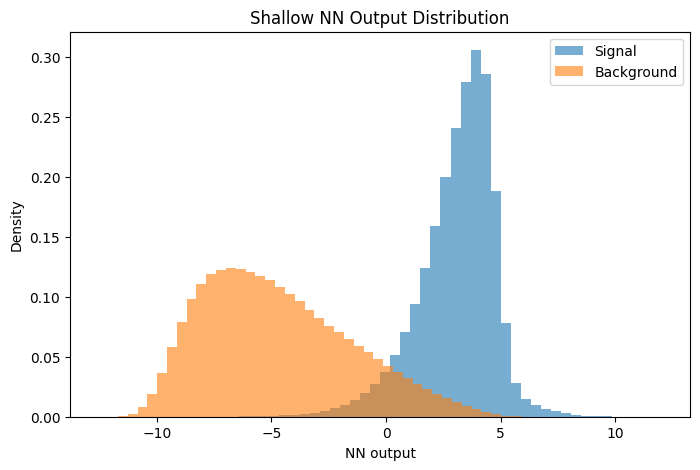

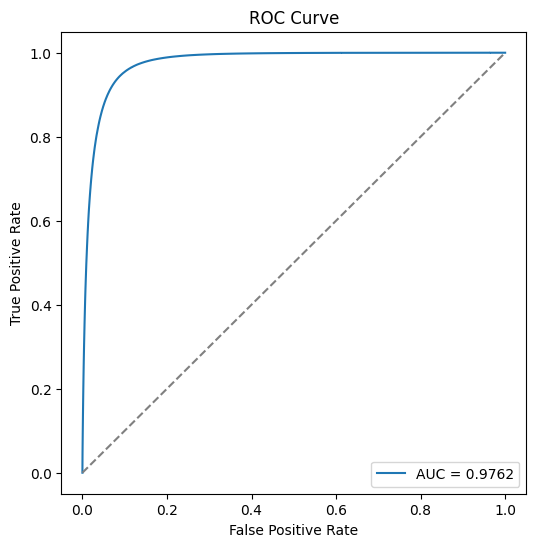

AUC: 0.9762094028534742


In [ ]:
# Get predictions
y_true, y_pred = get_predictions(Dmodel, test_1000_loader, device)

# Output distributions
plot_output_distribution(y_true, y_pred)

# ROC curve & AUC
auc_value = plot_roc_curve(y_true, y_pred)
print("AUC:", auc_value)

We see that the AUC from the shallow NN is 0.9736, while the AUC from deeper NN is 0.9762. So deeper NN indeed will increase the AUC.